# Plot the landscape

This notebook loads the information stored in the `landscape_info.pkl` and `annotations_info.pkl` files 
and visualises different aspects of the speaker landscapes. Some of the techniques also need to load the word embedding from ``word_embedding.emb``. 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.lines import Line2D
from gensim.models import KeyedVectors
import plotly.express as px

## 1. Load information

In [53]:
df = pd.read_pickle("landscape_info.pkl")

In [65]:
# unpack column
df['x'] = df.apply(lambda row: row['low_dim_vec'][0], axis=1)
df['y'] = df.apply(lambda row: row['low_dim_vec'][1], axis=1)

# make nicely formatted string for interactive plotlabel
def fmt(str_lst):
    new_list = [" <br> ".join(s[i:i+100] for i in range(0, len(s), 100)) for s in str_lst]
    new_list = " <br><br> ".join(new_list)
    return " <br> " + new_list
df['tweets'] = df.apply(lambda row: fmt(row["quotes"]), axis=1)

df.head()

,author,quotes,vec,low_dim_vec,x,y,tweets
0,agent_0sternchen,[@mountaindream5 @spaet68er @zuma_monty nur fü...,"[-0.0072948337, 0.08525834, 0.088255815, 0.030...","[9.962139, 6.6214237]",9.962139,6.621424,<br> @mountaindream5 @spaet68er @zuma_monty n...
1,agent_1st_rins,"[@zuma_okemaru @1st_rins 1st_rins, @zuma_okema...","[-0.07338741, 0.038354628, 0.07268287, 0.04553...","[10.167288, 7.139133]",10.167288,7.139133,<br> @zuma_okemaru @1st_rins 1st_rins <br> <...
2,agent_80pfarelo,[@frasimphi @coruscakhaya you will follow this...,"[-0.030285044, -0.027092239, 0.012962351, 0.04...","[3.380585, 7.387287]",3.380585,7.387287,<br> @frasimphi @coruscakhaya you will follow...
3,agent___xmo4,"[@zuma_okemaru ご飯食べたらあそぼ！, @zuma_okemaru ご飯食べた...","[-0.044664677, 0.028426673, 0.043664575, 0.035...","[9.915042, 6.950782]",9.915042,6.950782,<br> @zuma_okemaru ご飯食べたらあそぼ！ <br> <br> <br...
4,agent__africansoil,[💻pres zuma discussion with the top 6 presiden...,"[-0.097087175, 0.06697575, -0.17402579, -0.052...","[5.191036, 6.15981]",5.191036,6.159810,<br> 💻pres zuma discussion with the top 6 pre...


In [30]:
df_annotations = pd.read_pickle("annotations_info.pkl")

In [31]:
speakers = df["author"].tolist()
speakers_positions = df["low_dim_vec"].tolist()

annotations = df_annotations["word"].to_list()[:10]
annotations_positions = df["low_dim_vec"].tolist()[:10]

## 2. Plot annotated landscape

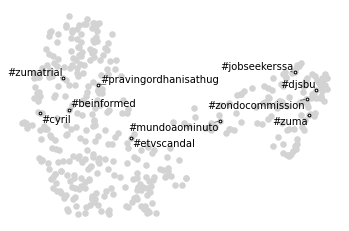

In [32]:
fig = plt.figure()

plt.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=30, c="lightgray")

texts = []
for i, word in enumerate(annotations):
    texts.append(plt.text(annotations_positions[i][0], annotations_positions[i][1], word, fontsize=10, color="black"))
adjust_text(texts, [a[0] for a in annotations_positions], [a[1] for a in annotations_positions], arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
plt.scatter([a[0] for a in annotations_positions], [a[1] for a in annotations_positions], s=30, marker='.', facecolors=(1,1,1,1), edgecolors=(0, 0, 0, 1), zorder=4)

plt.axis("off")
plt.show()

## 3. Inspect tweets of authors 


In [64]:
# for this we make the plot interactive using plotly

fig = px.scatter(df, x="x", y="y", hover_data=['author','tweets'])

fig.show()

## 4. Projection to anger

In [ ]:
anger_words = ["fuck", "shit", "fucking", "damn", "asshole", "assholes" "fucker", "bloody", "stupid", 
               "gun", "will", "murder", "kill", "violence", "wrong",
               "shoot", "bad", "death", "attack", "feel", "shot", "action",
               "arm", "idiot", "crazy", "criminal", "terrorist", "mad", "hell",
               "crime", "blame", "fight", "ridicule", "insane", "die",
               "threat", "terror", "hate"] 

embedding = KeyedVectors.load("word_embedding.emb")
vocab = embedding.index_to_key

# remove anger words that are not in the embedding's vocab (since they were not in the text corpus)
not_in_vocab = [word for word in anger_words if word not in vocab]
anger_words = [word for word in anger_words if word not in not_in_vocab]
anger_words

In [ ]:
projections_anger = []

for speaker in speakers:
    distances = []
    for anger_word in anger_words:
        distances.append(np.dot(embedding[speaker], embedding[anger_word]))
    projections_anger.append(np.mean(distances))
    
# we standarise the values...
mean = np.mean(projections_anger)
projections_anger = [x-mean for x in projections_anger]
# and overemphasise extremes with a nonlinear function
projections_anger = [np.tanh(7*x) for x in projections_anger]

In [ ]:
fig, ax1 = plt.subplots(1, 1)
plot = ax1.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=10, 
                   cmap="coolwarm", c=projections_anger, vmin=min(projections_anger), vmax=max(projections_anger))
ax1.axis("off")
fig.colorbar(plot)

## 5. Tweet length

In [ ]:
speaker_tweets = df.quotes.to_list()
lengths = [np.mean([len(t) for t in tweets]) for tweets in speaker_tweets]

In [ ]:
fig, ax1 = plt.subplots(1, 1)
plot = ax1.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=10, 
                   cmap="plasma", c=lengths, vmin=1, vmax=240)
ax1.axis("off")
fig.colorbar(plot)

## 6. Emoji count

In [ ]:
from emoji import UNICODE_EMOJI
import emoji
import re

In [ ]:
speaker_tweets = df.quotes.to_list()
average_num_emojis = [np.mean([len(re.findall(u'[\U0001f600-\U0001f999]', t)) for t in tweets]) for tweets in speaker_tweets]

In [ ]:
fig, ax1 = plt.subplots(1, 1)
plot = ax1.scatter([s[0] for s in speakers_positions], [s[1] for s in speakers_positions], s=10, 
                   cmap="viridis_r", c=average_num_emojis, vmin=0, vmax=0.5)
ax1.axis("off")
fig.colorbar(plot)